In [1]:
# Library imports
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from sklearn import metrics
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, utils

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import config
from data import get_train_test_images_data_dict, ParasiteDataset
from contour import *

In [2]:
# map the class names to labels
CLASS_DICT = {
    "parasitized_subset" : 1,
    "uninfected_subset" : 0 
}

print("Class Names -> Labels:\n", CLASS_DICT)

# conversely mapping the labels to class names
CLASS_NAMES = {v: k for k, v in CLASS_DICT.items()} 
print("\n\nClass Labels -> Names:\n", CLASS_NAMES)

Class Names -> Labels:
 {'parasitized_subset': 1, 'uninfected_subset': 0}


Class Labels -> Names:
 {1: 'parasitized_subset', 0: 'uninfected_subset'}


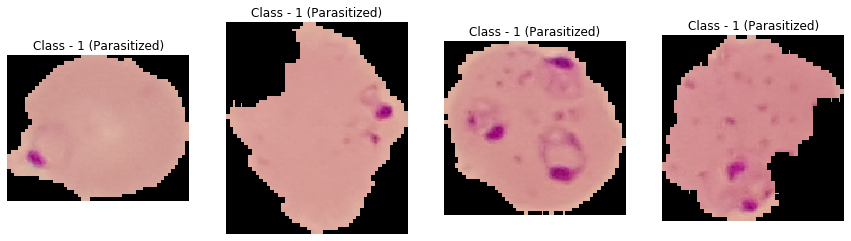

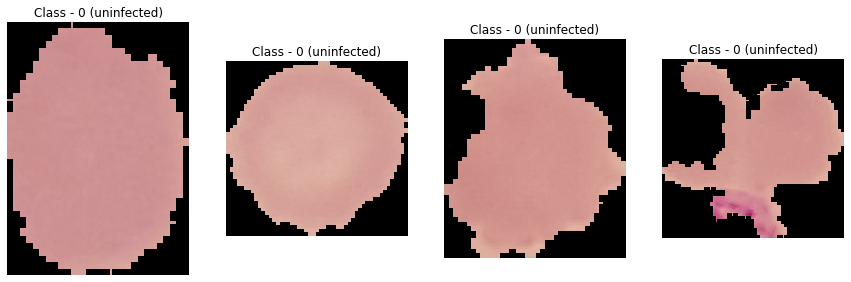

In [3]:
def plot_distinct_classes(data_path:str, figsize:tuple=(15, 12)):
    """
    Collects the first image path from each class folder and plots it.
    :param data_path: Root directory of the image dataset.
    :param figsize: Size of te figure to be plotted. 
    """
    images_dict = {}
    for dir in os.listdir(data_path):
        if dir == '.gitignore':
            continue
        image_names = os.listdir(os.path.join(data_path, dir))
        images = []
        for i, image_name in enumerate(image_names):
            if i < 4:
                img = Image.open(os.path.join(data_path, dir, image_name))
                images.append(img)
            else:
                images_dict[dir] = images
                break

    fig1 = plt.figure(figsize=figsize)

    set1_figures = images_dict["parasitized_subset"]
    index = 141
    for i, img in enumerate(set1_figures):
        plt.subplot(index+i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Class - 1 (Parasitized)')  

    plt.show()

    fig2 = plt.figure(figsize=figsize)

    set2_figures = images_dict["uninfected_subset"]
    index = 141
    for i, img in enumerate(set2_figures):
        plt.subplot(index+i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Class - 0 (uninfected)')    

    plt.show()

plot_distinct_classes(data_path=os.path.join(config.ROOT_PATH, "parasite_dataset"))

# Training and Validation Functions

In [4]:
def get_accuracy(output, target):
    """
    Estimates accuracy of the model during training and valid phase.
    :param output: feature output from the model (use argmax to get labels).
    :param target: target labels.
    :returns: accuracy
    """
    predictions = torch.argmax(output.data, 1)
    accuracy = (predictions == target).sum().item() / target.size(0)
    return accuracy

def validate(model, device, loader, loss_criterion):
    """
    puts the model in evaluation mode and validates model.
    :param model: network model
    :param device: cpu / gpu
    :param loader: pytorch data loader
    :param loss_criterion: criterion to estimate loss.
    :returns: mean loss, accuracies and f1 score
    """
    model.eval()
    losses = []
    accuracies = []
    f1_scores = []
    for idx, (image, target) in enumerate(loader):
        
        image, target = image.to(device), target.to(device)
        
        out = model(image)
        
        loss = loss_criterion(out, target)
        losses.append(loss.item())
        
        accuracy = get_accuracy(out, target)
        accuracies.append(accuracy)

        f1_score = metrics.f1_score(target.unsqueeze(1).cpu().numpy().ravel(), torch.argmax(out.data, 1).cpu().numpy(), average='macro')
        f1_scores.append(f1_score)
    
    return np.mean(losses), np.mean(accuracies), np.mean(f1_scores)

def execute_trainstep(model, device, loader, loss_criterion, optimizer):
    """
    puts the model in training mode and trains.
    :param model: network model
    :param device: cpu / gpu
    :param loader: pytorch data loader
    :param loss_criterion: criterion to estimate loss.
    :returns: mean loss, accuracies and f1 score
    """
    model.train()
    losses = []
    accuracies = []
    f1_scores = []
    for idx, (image, target) in enumerate(loader):
        
        image, target = image.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        out = model(image)
        loss = loss_criterion(out, target)
        losses.append(loss.item())
        
        accuracy = get_accuracy(out, target)
        accuracies.append(accuracy)

        f1_score = metrics.f1_score(target.unsqueeze(1).cpu().numpy().ravel(), torch.argmax(out.data, 1).cpu().numpy(), average='macro')
        f1_scores.append(f1_score)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(losses), np.mean(accuracies), np.mean(f1_scores)

def train(epochs, model, device, train_loader, valid_loader, loss_criterion, optimizer):
    """
    Function that puts the model in training and eval mode.
    :param epochs: number of epochs
    :param model: network to be trained
    :param device: cpu / gpu
    :param train_loader: pytorch data loader containing training images and targets.
    :param valid_loader: pytorch data loader containing valid images and targets.
    :returns: list of losses, accuracies and f1 scores for all epochs. 
    """
    train_losses = []
    valid_losses = []
    
    train_accuracies = []
    valid_accuracies = []

    train_f1_scores = []
    valid_f1_scores = []

    for epoch in range(1, epochs+1):
        
        start = time.time()
        
        train_loss, train_accuracy, train_f1_score = execute_trainstep(model, device, train_loader, loss_criterion, optimizer)
        valid_loss, valid_accuracy, valid_f1_score = validate(model, device, valid_loader, loss_criterion)
        
        end = time.time()
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        train_f1_scores.append(train_f1_score)
        valid_f1_scores.append(valid_f1_score)

        print(f"""\nEpoch {epoch}/{epochs} Time : {end-start:.2f}s 
                Training Loss : {train_losses[-1]:.6f} Validation Loss : {valid_losses[-1]:.6f}
                Training Accuracy : {train_accuracies[-1]*100:.2f}% Validation Accuracy : {valid_accuracies[-1]*100:.2f}%
                Training F1 Score : {train_f1_scores[-1]*100:.2f}% Validation F1 Score : {valid_f1_scores[-1]*100:.2f}%""")
        
    return train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_scores, valid_f1_scores

# Network Module
A series of Convolutional, Batchnormalisation, Pooling layers with ReLU activations and a fully connected network with dropout is used in this case to classify images with/without parasite.

In [17]:
def init(m, initialization_type):
    """
    Initializes weight and biases in the layer as per the chosen initialization_type
    :param m: layer module
    :param initialization_type: type of initialization (orthogonal | normal)
    :returns: initialized layer module as per chosen initialization type.
    """
   
    if initialization_type=='orthogonal':
        nn.init.orthogonal_(m.weight.data)
        m.weight.data*=1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)
        return m

    if initialization_type=='normal':
        nn.init.normal_(m.weight.data, 0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)
        return m


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        init_ = lambda m: init(m, initialization_type='normal')
        self.features = nn.Sequential(
                                nn.Conv2d(3, 16, 3),
                                nn.BatchNorm2d(16, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(16, 12, 3),
                                nn.BatchNorm2d(12, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(12, 24, 3),
                                nn.BatchNorm2d(24, affine = False),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(24, 48, 3),
                                nn.BatchNorm2d(48, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(48, 96, 3),
                                nn.BatchNorm2d(96, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                        )
        self.classifier = nn.Sequential(
                                nn.Linear(96*4*4,1000),
                                nn.Tanh(),
                                nn.Dropout(p=0.2),
                                nn.Linear(1000, 2),
                                nn.Tanh()
                        )
                                
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 96*4*4)
        x = self.classifier(x)
        return x

# Loss Function and Optimizer

- 'Adam' optimizer with a learning rate of 0.001 is chosen.
- Categorical crossentropy loss is chosen as the Loss function.

In [6]:
print(config.DEVICE)

torch.cuda.empty_cache()

net = Net().to(config.DEVICE)

lr = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

cuda


# Data Transformations
- The images are resized to 128x128
- Randomly Flipped horizontally with a probability of 0.5 (which is default)
- Transformed to tensors
- A batch size of 32 worked in this case.

In [7]:
transformer = transforms.Compose([
                    transforms.Resize((128, 128)),
                    transforms.RandomHorizontalFlip(),                    
                    transforms.ToTensor()
                ])

train_valid_images_dict, test_dict = get_train_test_images_data_dict(
    data_path=os.path.join(config.ROOT_PATH, "parasite_dataset"),
    test_size=config.TEST_SIZE
)

train_dataset = ParasiteDataset(
    data_path=os.path.join(config.ROOT_PATH, "parasite_dataset"),
    class_dict=CLASS_DICT,
    train_test_image_data_dict=train_valid_images_dict,
    train=True,
    transform=transformer
)

valid_dataset = ParasiteDataset(
    data_path=os.path.join(config.ROOT_PATH, "parasite_dataset"),
    class_dict=CLASS_DICT,
    train_test_image_data_dict=train_valid_images_dict,
    train=False,
    transform=transformer
)

batch_size = 16
train_loader = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.dataloader.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Training
The model is trained for 25 epochs to achieve ~98% accuracy on testing data and ~94% on the test data. This is achieved after trying out different architectures and different hyperparameters (batch size, learning rate ...). 
Training images are used for training and validation images are used for validating the network whilst training.

## Evaluation Metrics:
- Accuracy and F1 score is used as the evaluation metric. 

In [8]:
# start training
s = time.time()
n_epochs = 25
train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_scores, valid_f1_scores = train(n_epochs, net, config.DEVICE, 
                                                train_loader, valid_loader, criterion, optimizer)

print(f"TOTAL TIME: {time.time()-s:.2f}s")                                                


Epoch 1/25 Time : 3.53s 
                Training Loss : 0.571939 Validation Loss : 0.752410
                Training Accuracy : 69.22% Validation Accuracy : 56.88%
                Training F1 Score : 67.69% Validation F1 Score : 49.19%

Epoch 2/25 Time : 2.39s 
                Training Loss : 0.486508 Validation Loss : 0.460091
                Training Accuracy : 77.97% Validation Accuracy : 80.62%
                Training F1 Score : 77.17% Validation F1 Score : 79.43%

Epoch 3/25 Time : 3.44s 
                Training Loss : 0.454506 Validation Loss : 0.398314
                Training Accuracy : 78.44% Validation Accuracy : 80.00%
                Training F1 Score : 77.69% Validation F1 Score : 79.34%

Epoch 4/25 Time : 4.07s 
                Training Loss : 0.392136 Validation Loss : 0.351581
                Training Accuracy : 82.19% Validation Accuracy : 85.62%
                Training F1 Score : 81.61% Validation F1 Score : 85.31%

Epoch 5/25 Time : 2.03s 
                Traini

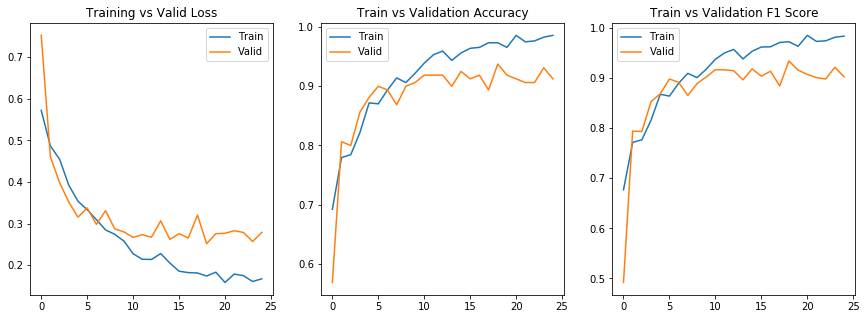

In [9]:
fig1 = plt.figure(figsize=(20, 5))

# Loss
plt.subplot(141)
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Valid')
plt.title("Training vs Valid Loss")
plt.legend()

# Accuracy
plt.subplot(142)
plt.plot(train_accuracies, label ='Train')
plt.plot(valid_accuracies, label ='Valid')
plt.title("Train vs Validation Accuracy")
plt.legend()

# F1 Score
plt.subplot(143)
plt.plot(train_f1_scores, label ='Train')
plt.plot(valid_f1_scores, label ='Valid')
plt.title("Train vs Validation F1 Score")
plt.legend()

plt.show()

# Resnet Training

In [8]:
torch.cuda.empty_cache()

from torchvision.models.resnet import resnet18

resNet = resnet18(pretrained=True)
resNet.fc = torch.nn.Linear(512, 2)

resNet.to(config.DEVICE)


lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [9]:
# start training
s = time.time()
n_epochs = 25
train_losses, valid_losses, train_accuracies, valid_accuracies, train_f1_scores, valid_f1_scores = train(n_epochs, resNet, config.DEVICE, 
                                                train_loader, valid_loader, criterion, optimizer)

print(f"TOTAL TIME: {time.time()-s:.2f}s")    


Epoch 1/25 Time : 4.13s 
                Training Loss : 0.928405 Validation Loss : 0.795034
                Training Accuracy : 50.16% Validation Accuracy : 51.25%
                Training F1 Score : 35.76% Validation F1 Score : 38.74%

Epoch 2/25 Time : 2.80s 
                Training Loss : 0.922462 Validation Loss : 0.845847
                Training Accuracy : 51.25% Validation Accuracy : 53.12%
                Training F1 Score : 35.77% Validation F1 Score : 39.46%

Epoch 3/25 Time : 2.93s 
                Training Loss : 0.919663 Validation Loss : 0.836437
                Training Accuracy : 51.25% Validation Accuracy : 51.25%
                Training F1 Score : 36.29% Validation F1 Score : 38.33%

Epoch 4/25 Time : 2.93s 
                Training Loss : 0.915028 Validation Loss : 0.829943
                Training Accuracy : 51.09% Validation Accuracy : 52.50%
                Training F1 Score : 36.17% Validation F1 Score : 40.55%

Epoch 5/25 Time : 2.89s 
                Traini

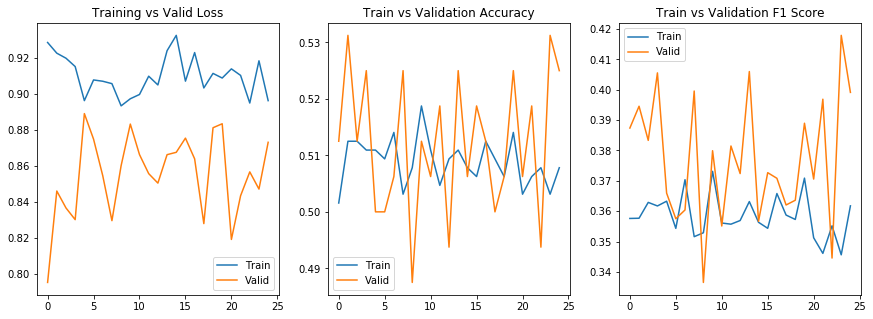

In [10]:
fig1 = plt.figure(figsize=(20, 5))

# Loss
plt.subplot(141)
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Valid')
plt.title("Training vs Valid Loss")
plt.legend()

# Accuracy
plt.subplot(142)
plt.plot(train_accuracies, label ='Train')
plt.plot(valid_accuracies, label ='Valid')
plt.title("Train vs Validation Accuracy")
plt.legend()

# F1 Score
plt.subplot(143)
plt.plot(train_f1_scores, label ='Train')
plt.plot(valid_f1_scores, label ='Valid')
plt.title("Train vs Validation F1 Score")
plt.legend()

plt.show()

In [10]:
# save the model parameters
torch.save(net.state_dict(), os.path.join(config.ROOT_PATH, 'src/trained_models', 'baseline_model_ep_'+str(n_epochs)+'.pt'))

# Visualizing Predictions With Localization (Only On Base Architecture)

In [18]:
# initialize network.
net = Net().to(config.DEVICE)

# load model param from path.
net.load_state_dict(torch.load(os.path.join(config.ROOT_PATH, 'src', 'trained_models', 'baseline_model_ep_25.pt')))

# put model in eval mode
net.eval()

Net(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

In [52]:
def get_prediction_from_model(idx, dataset, model, device):
    """
    Returns predicted label, target and the image
    of the input index from the dataset.
    :param idx: index of the sample in the dataset.
    :param dataset: pytorch dataset
    :param model: network model
    :param devie: cpu / cuda
    """
    origImage, target = dataset[idx]
    image = origImage.clone()
    image = image.unsqueeze(0).to(device)
    output = model(image)
    prediction = torch.argmax(output.data, 1).cpu().item()
    return prediction, target, origImage


def show_image_predictions_with_localization(device, dataset, model, fig_size=(30, 20)):    
    """
    -> Plots the images along with predicted and target labels.
    For images that are predicted positive (parasitized) by the model,
    a localization is carried out to localize the infected area by a contour.
    
    -> The localization is carried out by LocalizeParasite() module from contour.py.

    :param device: cpu / cuda.
    :param dataset: pytorch dataset from which samples are chosen at random for testing.
    :param model: trained network model. 
    :param figsize: canvas size for plotting.
    :returns: void.
    """
    fig = plt.figure(figsize=fig_size)
    n_columns = 5
    localizeParasite = LocalizeParasite(contourRGB=(255,0,0))
    for i in range(n_columns):
        n = np.random.randint(len(dataset))
        pred, target, img = get_prediction_from_model(n, dataset, model, device)       
        if pred == 1:  
            imgg = img          
            pim = localizeParasite.prepareImage(img)
            img = localizeParasite.getContourImage(pim, applyThresholding=True, filterContours=True)            
        else:
            img = np.moveaxis(img.cpu().numpy(), 0, -1)                       
        plt.subplot(100 + n_columns*10 + 1 + i)        
        plt.title(f"Target: {CLASS_NAMES[target].split('_')[0]}")
        plt.text(40,145,f"Predicted:{CLASS_NAMES[pred].split('_')[0]}")
        plt.imshow(img)
    return imgg

#### As shown, the model correctly predicts an image either as parasitized / uninfected.
#### The localization for images are shown that are predicted as parasitized.

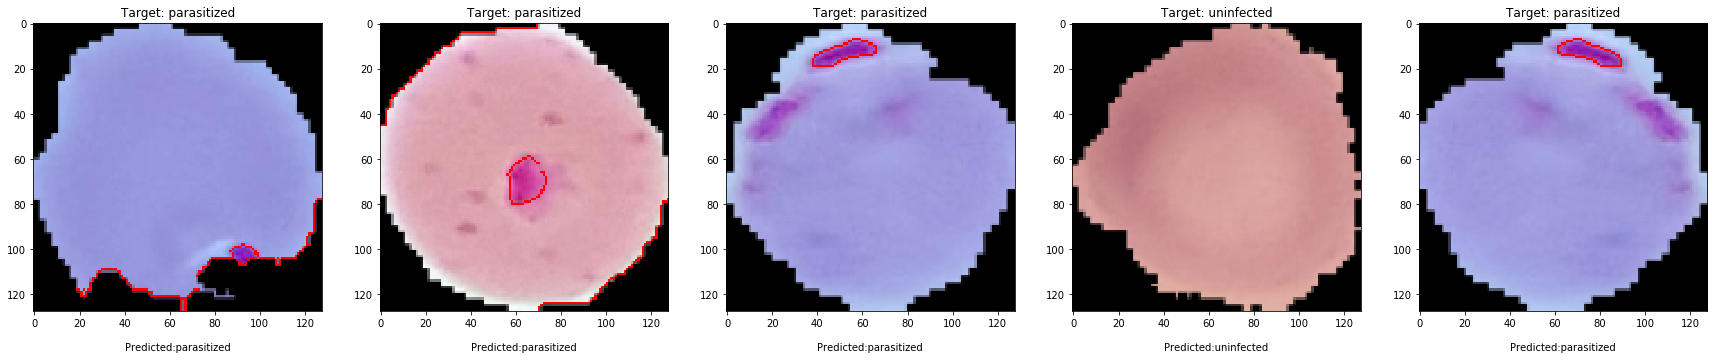

In [55]:
im = show_image_predictions_with_localization(device=config.DEVICE, dataset=valid_dataset, model=net)

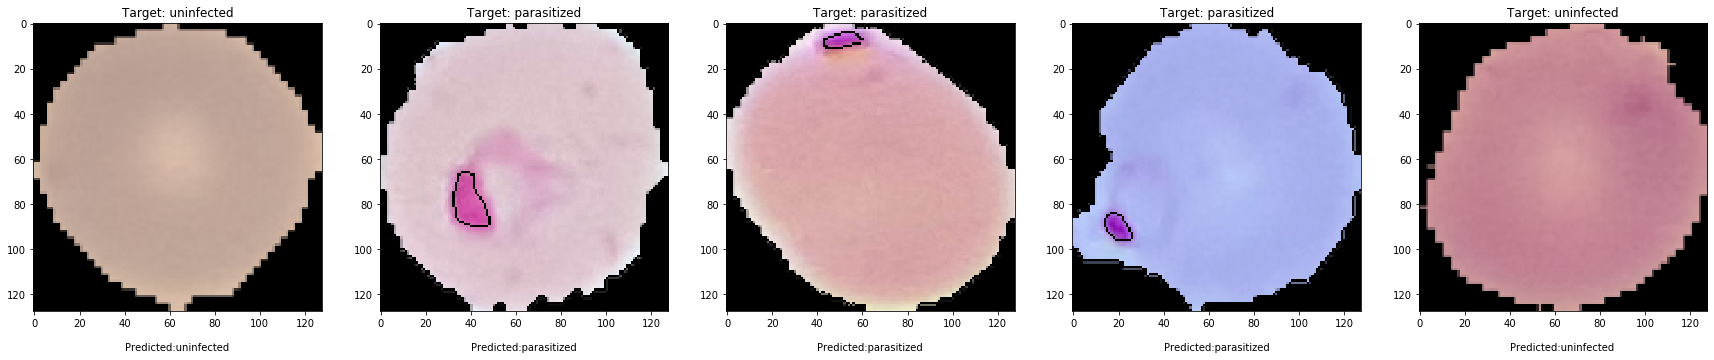

In [37]:
show_image_predictions_with_localization(device=config.DEVICE, dataset=valid_dataset, model=net)

In [46]:
def filter_contours(contours, hierachy, softing=0.2):      
    """
    Method to filter contour to remove contours that are not useful with
    For e.g. contours at the image boundary.
    :param contours: list of coordinates.
    :param hierachy: contains information about the image topology, it is an array of 4 element 
    [Next, Previous, First_Child, Parent].
    :returns: filtered contour.
    """
    areas = []
    filtered_contours = []
    l = []          
    for e, h in enumerate(hierachy[0]):
        # In the hierarchy array scan the Parent column (4th column) 
        # to see whether it has no parent contours (-1) and append them.
        if h[3] == -1:
            l.append(e)

    contours_ = []
    for o in l:
        # compute contour area. 
        areas.append(cv2.contourArea(contours[o]))
        # append contours that as no parent cotour
        contours_.append(contours[o])

    print(np.mean(areas))
    print(np.max(areas))
    # compute a threshold based on contour area.
    contThreshold = np.mean(areas) + softing*np.max(areas)

    for cont in contours_:
        if cv2.contourArea(cont) > 10:
            # append those contour that has contour area > threshold
            filtered_contours.append(cont) 

    return filtered_contours

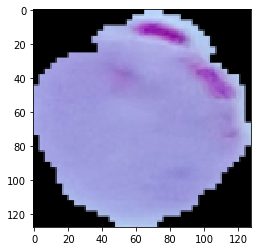

In [59]:
image_ = np.moveaxis(im.cpu().numpy(), 0, -1)


# normalize pixels between 0 and 255
image_ *= 255.0 / image_.max()
image_ = image_.astype(np.uint8)

image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)

plt.imshow(image_)

_, thresholdImage = cv2.threshold(
    image_, 
    110, 
    175,
    cv2.THRESH_BINARY
)


cannyImage = cv2.Canny(
    thresholdImage, 
    10,
    100
)

# findContour function that helps in extracting the contours from the image. 
# It works best on binary images, so we should first apply thresholding techniques.
contours_, hierachy_ = cv2.findContours(
    cannyImage,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

# contours_ = filter_contours(
#     contours=contours_, 
#     hierachy=hierachy_
# )

drawContours = cv2.drawContours(
    image=image_, 
    contours=contours_, 
    contourIdx=-1, 
    color=(255,0,0), 
    lineType=1
)



# References:

- https://pytorch.org/
- https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html#:~:text=Canny%20does%20use%20two%20thresholds,threshold%2C%20then%20it%20is%20rejected.
- https://www.geeksforgeeks.org/find-and-draw-contours-using-opencv-python/